In [1]:
import numpy as np

In [2]:
pip install sarabande

Note: you may need to restart the kernel to use updated packages.


In [3]:
import sarabande

sarabande.check_install()


Checking to see if sarabande is properly imported... 

a simple function to make sure this module works.

Now running configuration tests... 

sarabande has been succesfully installed.


In [4]:
#Preamble
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.axes_grid1 as axgrid
from mpl_toolkits.axes_grid1 import make_axes_locatable
import astropy.io.fits as pyf
import os
import sarabande

plt.style.use("default")

In [5]:
f = open("Desktop\data\dens_t800.fits")
print(f.read())

FileNotFoundError: [Errno 2] No such file or directory: 'Desktop\\data\\dens_t800.fits'

In [ ]:
#import data from CATS

hdulist = pyf.open("desktop/data/dens_t800.fits")
data = hdulist[0].data.astype(np.float64)

data = data[:128,:128,:128] # for sake of fast computation
data -= np.mean(data)

In [1]:
fig, (ax1) = plt.subplots(1,1, figsize=(7,7))
im1 = ax1.imshow(data[:,:,64], cmap='hot', origin='lower')
# divider1 = axgrid.make_axes_locatable(ax1)
# cax1 = divider1.append_axes("right", size='5%', pad=0.05)
# plt.colorbar(im1, cax=cax1)
ax1.set_title("Projected Density Field", fontsize=35, pad=15)
ax1.set_xlabel("x-axis", fontsize=35)
ax1.set_ylabel("y-axis", fontsize=35)
ax1.set_xticks([])
ax1.set_yticks([])
fig.tight_layout()
# plt.savefig("projected-example.png", dpi=300)
plt.show()

NameError: name 'plt' is not defined

In [ ]:
ls

In [ ]:
mkdir MHDdata

In [ ]:
ls

In [ ]:
cd MHDdata

In [ ]:
git clone https://github.com/James11222/sarabande.git

# SARABANDE

Code from Google Colab

In [10]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [11]:
import numpy as np
from subprocess import call
import astropy.io.fits as pyf
import matplotlib.pyplot as plt


plt.rcParams['mathtext.fontset'] = 'stix' 
plt.rcParams['font.family'] = 'STIXGeneral' 
plt.rcParams['font.size'] = 22

## Step 1: Make the kernels

In [12]:
save_name = 'demo'
eps = 1e-15
ell_max = 2
nbins = 4
#don't set it to zero, because spherical harmonics are ill-defined at the origin
bin_min = 1-1e-5
#radius from the origin.
bin_max = 128+1e-5

switch = {
	'LIN' : np.linspace(bin_min, bin_max, nbins+1),
	'INV' : 1./np.linspace(1./bin_min, 1./bin_max, nbins+1),
	'LOG' : np.exp(np.linspace(np.log(bin_min), np.log(bin_max), nbins+1))
}
bin_edges = switch['LIN']
ld_one_d = 256
boxsize = ld_one_d
N_mesh = ld_one_d

In [14]:
x = np.linspace(-ld_one_d/2, ld_one_d/2-1 , ld_one_d)
xsq = x*x
m_center = np.where(x==0)[0][0]
X, Y, Z = np.meshgrid(x, x, x, indexing='ij')
X = -X
Y = -Y
Z = -Z
Xsq, Ysq, Zsq = np.meshgrid(xsq, xsq, xsq,indexing='ij')
#PRECOMPUTE POWERS OF ARRAYS AND COMBINATIONS (e.g. x - iy).
Rsq = Xsq+Ysq+Zsq
R = np.sqrt(Rsq)
del Rsq
zero_ind = np.where(R==0)
R[zero_ind] = eps
X[zero_ind] = eps
Y[zero_ind] = eps
Z[zero_ind] = eps

In [15]:
boundsandnumber = np.zeros((2, nbins+1))
boundsandnumber[0,:] = bin_edges
for i in range(nbins):
  boundsandnumber[1,i] = np.sum(np.logical_and(R >= bin_edges[i],
                                               R < bin_edges[i+1]))
np.save('bin_bounds_and_pixel_number_'+save_name+'.npy',boundsandnumber)

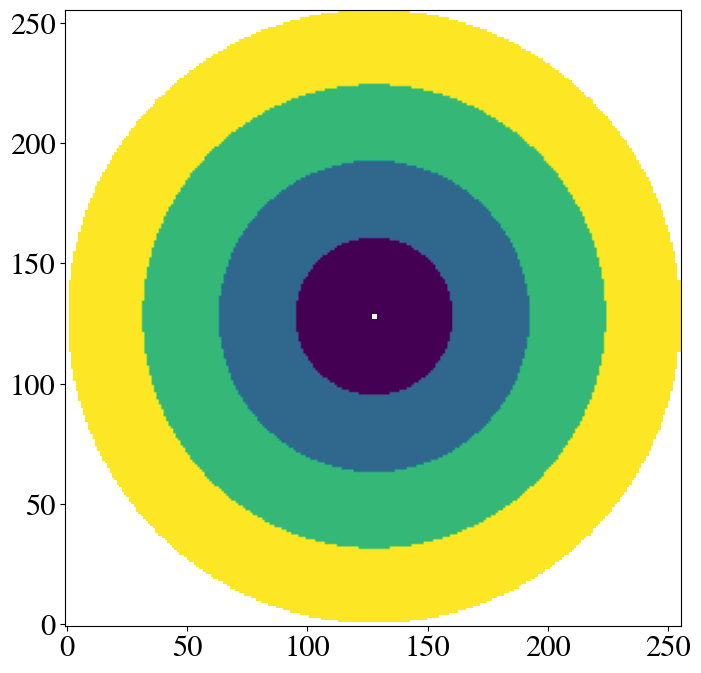

In [16]:
whichbin = np.full_like(R, float('nan'))
for i in range(nbins):
  mask = np.logical_and(R >= bin_edges[i], R < bin_edges[i+1])
  whichbin[mask] = i

plt.figure(figsize=(8,8))
plt.imshow(whichbin[ld_one_d//2,:,:], origin='lower')
# plt.savefig('radial_bins.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [26]:
def ylm_save(ylm, ell, m):
    np.save('ylm_'+save_name+'_'+str(ell)+'_'+str(m)+'.npy',ylm)#zs: to work on my laptop.
    del ylm

def ylm_transform_save(ylm_on_shell, ell, m, i):
    FT = np.fft.fftn(np.fft.fftshift(ylm_on_shell))
    np.save('YLMtilde_'+save_name+'_'+str(ell)+'_'+str(m)+'_bin_'+str(i)+'.npy',FT)
    del FT

In [ ]:
#COMPUTE YLMS SEQUENTIALLY AND SAVE.
#ell, m = 0,0
y00 =.5*(1./np.pi)**.5*np.ones((ld_one_d,ld_one_d,ld_one_d))
ylm_save(y00, 0, 0)
del y00

#ell, m = 1, -1
xdivr = X/R
del X
ydivr = Y/R#we'll need these as individuals later anyway.
del Y
xmiydivr = xdivr - 1j*ydivr
y1m1 = .5*np.sqrt(3./(2.*np.pi))*xmiydivr
ylm_save(y1m1, 1, 1)
del y1m1

#ell, m = 1, 0
zdivr = Z/R
del Z
y10 = .5*np.sqrt(3./np.pi)*zdivr
ylm_save(y10, 1, 0)
del y10

#ell, m = 2, -2
xmiydivrsq = xmiydivr*xmiydivr
y2m2 = .25*np.sqrt(15./(2.*np.pi))*xmiydivrsq
ylm_save(y2m2, 2, 2)
del y2m2

#ell, m = 2, -1
y2m1 = .5*np.sqrt(15./(2.*np.pi))*xmiydivr*zdivr
ylm_save(y2m1, 2, 1)
del y2m1

#ell, m = 2, 0
xdivrsq = xdivr*xdivr
ydivrsq = ydivr*ydivr
zdivrsq = zdivr*zdivr
y20 = .25*np.sqrt(5./np.pi)*(2.*zdivrsq-xdivrsq-ydivrsq)
ylm_save(y20, 2, 0)
del y20

#ell, m = 3, -3
xmiydivrcu = xmiydivr*xmiydivrsq
y3m3 = .125*np.sqrt(35./np.pi)*xmiydivrcu
ylm_save(y3m3, 3, 3)
del y3m3

#ell, m = 3, -2
y3m2 = .25*np.sqrt(105./(2.*np.pi))*xmiydivrsq*zdivr
ylm_save(y3m2, 3, 2)
del y3m2

#ell, m = 3, -1
y3m1 = .125*np.sqrt(21./np.pi)*(xmiydivr*(4.*zdivrsq-xdivrsq-ydivrsq))
ylm_save(y3m1, 3, 1)
del y3m1

#ell, m = 3, 0
y30 = .25*np.sqrt(7./np.pi)*(zdivr*(2.*zdivrsq-3.*xdivrsq-3.*ydivrsq))
ylm_save(y30, 3, 0)
del y30

#ell, m = 4, -4
xmiydivrft = xmiydivr*xmiydivrcu
y4m4 = .1875*np.sqrt(35./(2.*np.pi))*xmiydivrft
ylm_save(y4m4, 4, 4)
del y4m4

#ell, m = 4, -3
y4m3 = .375*np.sqrt(35./np.pi)*xmiydivrcu*zdivr
ylm_save(y4m3, 4, 3)
del y4m3

#ell, m = 4, -2
y4m2 = .375*np.sqrt(5./(2.*np.pi))*xmiydivrsq*(7.*zdivrsq-1)
ylm_save(y4m2, 4, 2)
del y4m2

#ell, m = 4, -1
y4m1 = .375*np.sqrt(5./np.pi)*xmiydivr*zdivr*(7.*zdivrsq-3.)
ylm_save(y4m1, 4, 1)
del y4m1

#ell, m = 4, 0
zdivrft = zdivrsq*zdivrsq
y40 = .1875*np.sqrt(1./np.pi)*(35.*zdivrft-30.*zdivrsq+3.)
ylm_save(y40, 4, 0)
del y40

#ell, m = 5, -5
xmiydivrfi = xmiydivr*xmiydivrft
y5m5 = (3./32.)*np.sqrt(77./np.pi)*xmiydivrfi
ylm_save(y5m5, 5, 5)
del y5m5

#ell, m = 5, -4
y5m4 = (3./16.)*np.sqrt(385./(2.*np.pi))*xmiydivrft*zdivr
ylm_save(y5m4, 5, 4)
del y5m4

#ell, m = 5, -3
y5m3 = (1./32.)*np.sqrt(385./np.pi)*xmiydivrcu*(9.*zdivrsq-1.)
ylm_save(y5m3, 5, 3)
del y5m3

#ell, m = 5, -2
zdivrcu = zdivr*zdivrsq
y5m2 = (1./8.)*np.sqrt(1155./(2.*np.pi))*xmiydivrsq*(3.*zdivrcu-zdivr)
ylm_save(y5m2, 5, 2)
del y5m2

#ell, m = 5, -1
y5m1 = (1./16.)*np.sqrt(165./(2.*np.pi))*xmiydivr*(21.*zdivrft-14.*zdivrsq+1.)
ylm_save(y5m1, 5, 1)
del y5m1

#ell, m = 5, 0
zdivrfi = zdivr*zdivrft
y50 = (1./16.)*np.sqrt(11./np.pi)*(63.*zdivrfi-70.*zdivrcu+15.*zdivr)
ylm_save(y50, 5, 0)
del y50

FileNotFoundError: [Errno 2] No such file or directory: 'ylm_dens_t800_1_0.npy'

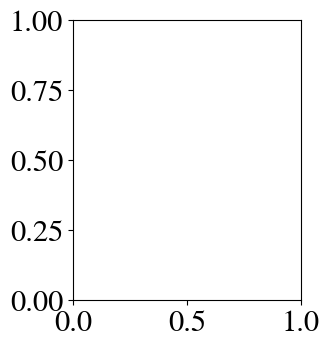

In [27]:
plt.figure(figsize=(10,8))
for ell in range(1, ell_max+1):
  for m in range(0, ell+1):
    plt.subplot(ell_max, ell_max+1, (ell-1)*(ell_max+1)+m+1)
    ylm = np.load('ylm_'+save_name+'_'+str(ell)+'_'+str(m)+'.npy')
    plt.imshow(ylm[:,ld_one_d//2,:].real, interpolation='none', vmin=-1, vmax=1, cmap='bwr', origin='lower')
    plt.xticks([])
    plt.yticks([])
    plt.title('l='+str(ell)+' m='+str(m))
plt.suptitle('x-z slices of real part of spherical harmonics', fontsize='xx-large')
plt.show()

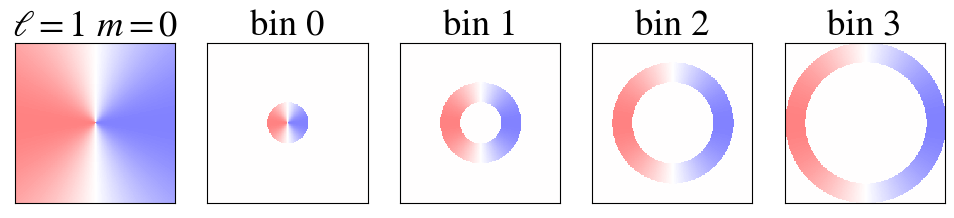

In [20]:
ell = 1
m = 0
ylm = np.load('ylm_'+save_name+'_'+str(ell)+'_'+str(m)+'.npy')
plt.figure(figsize=(12,6))
plt.subplot(1,nbins+1,1)
plt.imshow(ylm[:,ld_one_d//2,:].real, interpolation='none', vmin=-1, vmax=1, cmap='bwr')
plt.xticks([])
plt.yticks([])
plt.title('$\\ell=$'+str(ell)+' $m=$'+str(m))
for i in range(nbins):
  rib = np.where((R >= bin_edges[i]) & (R < bin_edges[i+1]))
  ylm_on_shell = np.zeros((ld_one_d, ld_one_d, ld_one_d)) + 0j
  ylm_on_shell[rib] = ylm[rib]
  plt.subplot(1,nbins+1,i+2)
  plt.imshow(ylm_on_shell[:,ld_one_d//2,:].real, interpolation='none', vmin=-1, vmax=1, cmap='bwr')
  plt.xticks([])
  plt.yticks([])
  plt.title('bin '+str(i))
plt.show()

In [21]:
for ell in range(0, ell_max+1):
  for m in range(0, ell+1):
    print("ell, m = ", ell, m)
    #do one ylm at a time to save lots of accessing memory
    ylm = np.load('ylm_'+save_name+'_'+str(ell)+'_'+str(m)+'.npy') 
    for i in range(nbins):
      print("bin i = ", i)
      #where is radius in bin?
      rib = np.where((R >= bin_edges[i]) & (R < bin_edges[i+1]))
      ylm_on_shell = np.zeros((ld_one_d, ld_one_d, ld_one_d)) + 0j
      ylm_on_shell[rib] = ylm[rib]
      del rib
      ylm_transform_save(ylm_on_shell, ell, m, i)
      del ylm_on_shell
    if 'ylm' in globals():
      del ylm
    file_to_rm = 'ylm_'+save_name+'_'+str(ell)+'_'+str(m)+'.npy'
    call(["rm", file_to_rm])

ell, m =  0 0
bin i =  0
bin i =  1
bin i =  2
bin i =  3
ell, m =  1 0
bin i =  0
bin i =  1
bin i =  2
bin i =  3
ell, m =  1 1
bin i =  0
bin i =  1
bin i =  2
bin i =  3
ell, m =  2 0
bin i =  0
bin i =  1
bin i =  2
bin i =  3
ell, m =  2 1
bin i =  0
bin i =  1
bin i =  2
bin i =  3
ell, m =  2 2
bin i =  0
bin i =  1
bin i =  2
bin i =  3


## Step 2: Convolve kernels with data

In [28]:
save_name = 'dens_t800'
kernel_name = 'demo'
file = save_name+'.fits.gz'

bin_bounds = np.load('bin_bounds_and_pixel_number_'+kernel_name+'.npy')
nbins = bin_bounds.shape[1] - 1

In [29]:
!wget https://users.flatironinstitute.org/~bburkhart/data/CATS/MHD/256/b.1p.32/t_800/dens_t800.fits.gz
!ls

--2023-03-01 19:27:16--  https://users.flatironinstitute.org/~bburkhart/data/CATS/MHD/256/b.1p.32/t_800/dens_t800.fits.gz
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.9
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|144.121.86.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58559678 (56M) [application/octet-stream]
Saving to: 'dens_t800.fits.gz.2'

dens_t800.fits.gz.2 100%[===================>]  55.85M  5.26MB/s    in 12s     

2023-03-01 19:27:28 (4.65 MB/s) - 'dens_t800.fits.gz.2' saved [58559678/58559678]

LICENSE
README.md
Tori's Notebook-ISM Project.ipynb
YLMtilde_demo_0_0_bin_0.npy
YLMtilde_demo_0_0_bin_1.npy
YLMtilde_demo_0_0_bin_2.npy
YLMtilde_demo_0_0_bin_3.npy
YLMtilde_demo_1_0_bin_0.npy
YLMtilde_demo_1_0_bin_1.npy
YLMtilde_demo_1_0_bin_2.npy
YLMtilde_demo_1_0_bin_3.npy
YLMtilde_demo_1_1_bin_0.npy
YLMtilde_demo_1_1_bin_1.npy
YLMtilde_demo_1_1_bin_2.npy
YLMtilde_demo_1_1_bin_3.npy
YLMtild

In [30]:
hdulist = pyf.open(file)
data = hdulist[0].data.astype(np.float64) #pull data
data -= np.mean(data) #subtract out the mean

#FT OF SHIFTED DATA
normalized = False # do log normalization
if normalized:
  data = (np.log(data) - np.mean(np.log(data)))/np.std(np.log(data))
ft_data = np.fft.fftn(data)

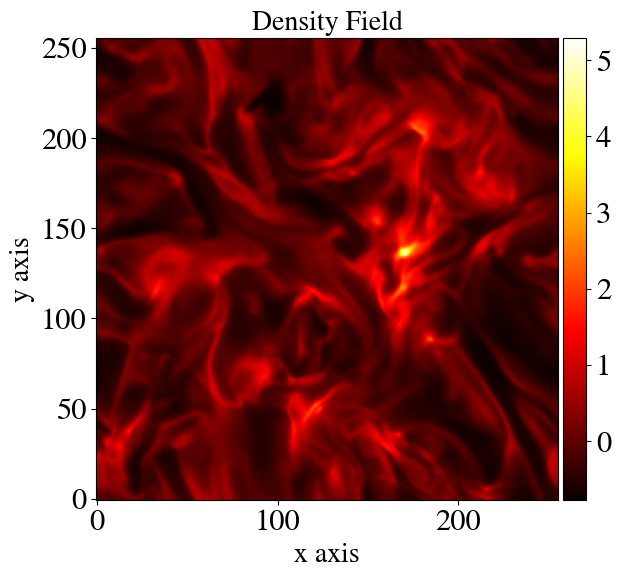

In [31]:
import mpl_toolkits.axes_grid1 as axgrid
from mpl_toolkits.axes_grid1 import make_axes_locatable

f, ax1 = plt.subplots(1,1,figsize=(8,6))
ax1.set_title("Density Field", fontsize=20)
ax1.set_xlabel("x axis", fontsize=20)
ax1.set_ylabel("y axis", fontsize=20)
im1 = ax1.imshow(data[:,:,ld_one_d//2], origin='lower', cmap="hot")
divider1 = axgrid.make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size='5%', pad=0.05)
plt.colorbar(im1, cax=cax1)
plt.show()

In [32]:
#CONVOLUTION OF DATA AND SPH_KERNEL AT A GIVEN BIN
for l in range(0, ell_max+1, 1):
  for m in range(0,l+1, 1):
    for bin in range(0, nbins, 1):
      print("l, m, bin =", l, m, bin)
      #load ft of bsph_kernels
      bsph_kernel = np.load('YLMtilde_'+kernel_name+'_'+str(l)+'_'+str(m)+
                            '_bin_'+str(bin)+'.npy')
      conv = np.fft.ifftn(ft_data*bsph_kernel)
      del bsph_kernel
      np.save(save_name+'conv_data_kernel_'+kernel_name+'_'+str(l)+'_'+str(m)+
              '_bin_'+str(bin)+'.npy', conv)
      del conv

l, m, bin = 0 0 0
l, m, bin = 0 0 1
l, m, bin = 0 0 2
l, m, bin = 0 0 3
l, m, bin = 1 0 0
l, m, bin = 1 0 1
l, m, bin = 1 0 2
l, m, bin = 1 0 3
l, m, bin = 1 1 0
l, m, bin = 1 1 1
l, m, bin = 1 1 2
l, m, bin = 1 1 3
l, m, bin = 2 0 0
l, m, bin = 2 0 1
l, m, bin = 2 0 2
l, m, bin = 2 0 3
l, m, bin = 2 1 0
l, m, bin = 2 1 1
l, m, bin = 2 1 2
l, m, bin = 2 1 3
l, m, bin = 2 2 0
l, m, bin = 2 2 1
l, m, bin = 2 2 2
l, m, bin = 2 2 3


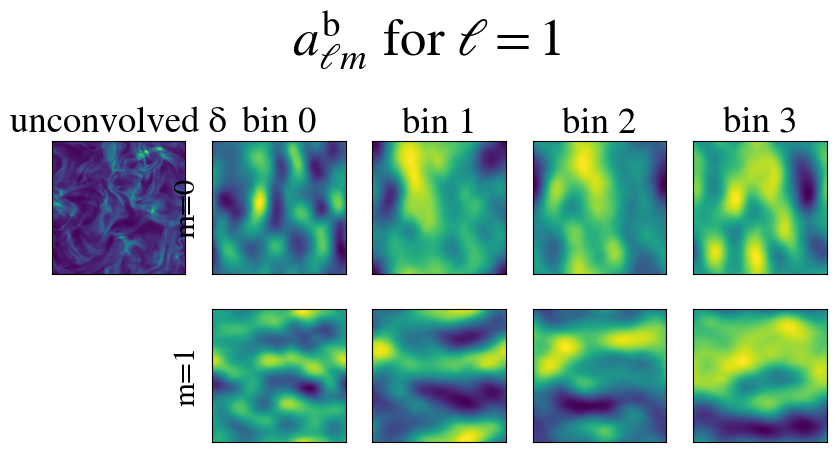

In [33]:
ell = 1
plt.figure(figsize=(10,4))
plt.subplot(2,nbins+1,1)
plt.imshow(data[:,ld_one_d//2,:])
plt.title('unconvolved δ')
plt.xticks([])
plt.yticks([])

for m in range(2):
  for bin in range(nbins):
    plt.subplot(2,nbins+1,m*(nbins+1)+bin+2)
    ylm_b = np.load(save_name+'conv_data_kernel_'+kernel_name+'_'+str(ell)+
                        '_'+str(m)+'_bin_'+str(bin)+'.npy').astype(np.complex128)
    plt.imshow(ylm_b[:,ld_one_d//2,:].real)
    if m == 0:
      plt.title('bin '+str(bin))
    if bin == 0:
      plt.ylabel('m='+str(m))
    plt.xticks([])
    plt.yticks([])
plt.suptitle('$a_{\ell m}^{\mathrm{b}}$ for $\ell=1$', fontsize='xx-large', y = 1.2)
plt.show()

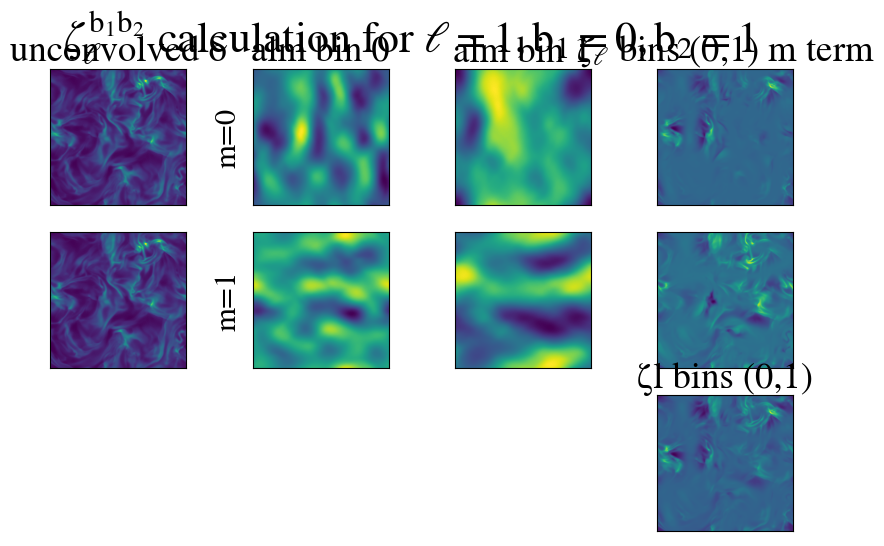

In [34]:
ell = 1
bin1 = 0
bin2 = 1
plt.figure(figsize=(10,6))
cumulate = np.zeros_like(data, dtype=np.complex128)
for m in range(0,ell+1, 1):
  ylm_b1 = np.load(save_name+'conv_data_kernel_'+kernel_name+'_'+str(ell)+
                      '_'+str(m)+'_bin_'+str(bin1)+'.npy').astype(np.complex128)
  ylm_b2 = np.load(save_name+'conv_data_kernel_'+kernel_name+'_'+str(ell)+
                      '_'+str(m)+'_bin_'+str(bin2)+'.npy').astype(np.complex128)
  plt.subplot(ell+2,4,m*4+1)
  if m == 0:
    plt.title('unconvolved δ')
  plt.imshow(data[:,ld_one_d//2,:])
  plt.xticks([])
  plt.yticks([])
  plt.subplot(ell+2,4,m*4+2)
  plt.imshow(ylm_b1[:,ld_one_d//2,:].real)
  if m == 0:
    plt.title('alm bin '+str(bin1))
  plt.xticks([])
  plt.yticks([])
  plt.ylabel('m='+str(m))
  plt.subplot(ell+2,4,m*4+3)
  plt.imshow(ylm_b2[:,ld_one_d//2,:].real)
  if m == 0:
    plt.title('alm bin '+str(bin2))
  plt.xticks([])
  plt.yticks([])
  plt.subplot(ell+2,4,m*4+4)
  if m == 0:
    plt.title('$\zeta_{\ell}$ bins ('+str(bin1)+','+str(bin2)+') m term')
  plt.imshow((data*ylm_b1*ylm_b2.conjugate())[:,ld_one_d//2,:].real)
  cumulate += data*ylm_b1*ylm_b2.conjugate()
  if m > 1:
    cumulate += data*ylm_b1.conjugate()*ylm_b2
  plt.xticks([])
  plt.yticks([])

plt.subplot(ell+2,4,(ell+1)*4+4)
plt.title('ζl bins ('+str(bin1)+','+str(bin2)+')')
plt.imshow((cumulate)[:,ld_one_d//2,:].real)
plt.xticks([])
plt.yticks([])

plt.suptitle('$\zeta_{\\ell}^{\\mathrm{b}_1 \\mathrm{b}_2}$ calculation for $\\ell=1, \\mathrm{b}_1=0, \\mathrm{b}_2=1$', fontsize='x-large')
plt.show()

## Step 3: Combine convolution coefficients

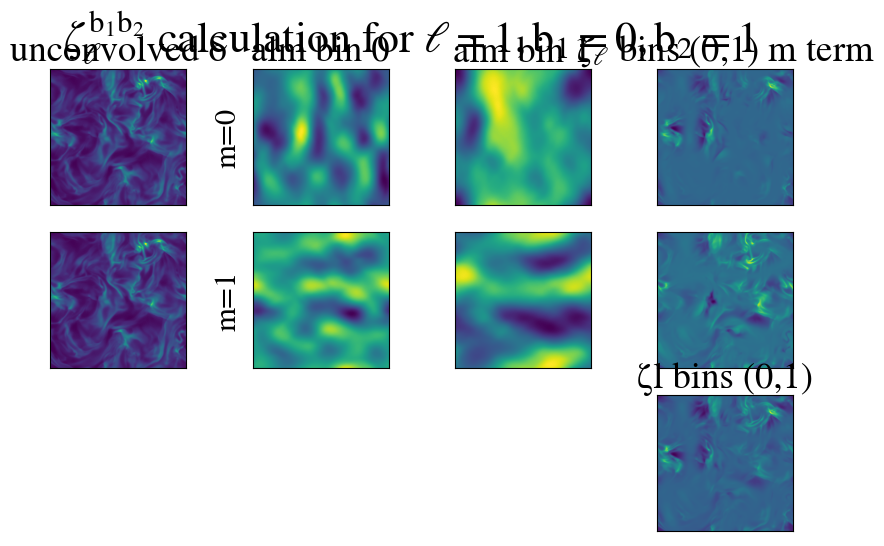

In [35]:
ell = 1
bin1 = 0
bin2 = 1
plt.figure(figsize=(10,6))
cumulate = np.zeros_like(data, dtype=np.complex128)
for m in range(0,ell+1, 1):
  ylm_b1 = np.load(save_name+'conv_data_kernel_'+kernel_name+'_'+str(ell)+
                      '_'+str(m)+'_bin_'+str(bin1)+'.npy').astype(np.complex128)
  ylm_b2 = np.load(save_name+'conv_data_kernel_'+kernel_name+'_'+str(ell)+
                      '_'+str(m)+'_bin_'+str(bin2)+'.npy').astype(np.complex128)
  plt.subplot(ell+2,4,m*4+1)
  if m == 0:
    plt.title('unconvolved δ')
  plt.imshow(data[:,ld_one_d//2,:])
  plt.xticks([])
  plt.yticks([])
  plt.subplot(ell+2,4,m*4+2)
  plt.imshow(ylm_b1[:,ld_one_d//2,:].real)
  if m == 0:
    plt.title('alm bin '+str(bin1))
  plt.xticks([])
  plt.yticks([])
  plt.ylabel('m='+str(m))
  plt.subplot(ell+2,4,m*4+3)
  plt.imshow(ylm_b2[:,ld_one_d//2,:].real)
  if m == 0:
    plt.title('alm bin '+str(bin2))
  plt.xticks([])
  plt.yticks([])
  plt.subplot(ell+2,4,m*4+4)
  if m == 0:
    plt.title('$\zeta_{\ell}$ bins ('+str(bin1)+','+str(bin2)+') m term')
  plt.imshow((data*ylm_b1*ylm_b2.conjugate())[:,ld_one_d//2,:].real)
  cumulate += data*ylm_b1*ylm_b2.conjugate()
  if m > 1:
    cumulate += data*ylm_b1.conjugate()*ylm_b2
  plt.xticks([])
  plt.yticks([])

plt.subplot(ell+2,4,(ell+1)*4+4)
plt.title('ζl bins ('+str(bin1)+','+str(bin2)+')')
plt.imshow((cumulate)[:,ld_one_d//2,:].real)
plt.xticks([])
plt.yticks([])

plt.suptitle('$\zeta_{\\ell}^{\\mathrm{b}_1 \\mathrm{b}_2}$ calculation for $\\ell=1, \\mathrm{b}_1=0, \\mathrm{b}_2=1$', fontsize='x-large')
plt.show()

In [36]:
import time

In [37]:
#load alms (results of convolution at fixed ell and for all m, to combine).
zeta = np.zeros((ell_max + 1, nbins, nbins)) + 0j

start = time.time()
for l in range(0, ell_max+1, 1):
    for bin1 in range(0, nbins, 1):
        for bin2 in range(0, bin1, 1):
            for m in range(0,l+1, 1):
                #load b1 and b2 at this m

                ylm_b1 = np.load(save_name +'conv_data_kernel_'+kernel_name+'_'+str(l)+
                                  '_'+str(m)+'_bin_'+str(bin1)+'.npy').astype(np.complex128)
                ylm_b2 = np.load(save_name+'conv_data_kernel_'+kernel_name+'_'+str(l)+
                                  '_'+str(m)+'_bin_'+str(bin2)+'.npy').astype(np.complex128)
                #form half of sum at that m.
                ylm_b1 *= ylm_b2.conjugate()
                del ylm_b2

                #average spatially now.
                ylm_avg = np.sum(data*ylm_b1)
                del ylm_b1
                # add in negative m: so basically we are computing m's in sum term by
                # term but with matching between + and - m.
                if m > 0:
                    ylm_avg += ylm_avg.conjugate() 
                zeta[l, bin1, bin2] += ylm_avg #now accumulate so we get sum over m.

#----------------
# Symmetrization
#----------------
for l in range(0, ell_max+1, 1):
    zeta[l, :, :] *= ((-1)**l / np.sqrt(2 * l + 1))
    for bin1 in range(0, nbins, 1):
        for bin2 in range(bin1, nbins, 1): 
            zeta[l, bin1, bin2] = zeta[l, bin2, bin1]

stop = time.time()

print(f"Full 3PCF Calculation Took: {stop - start:0.2f} seconds")

Full 3PCF Calculation Took: 35.80 seconds


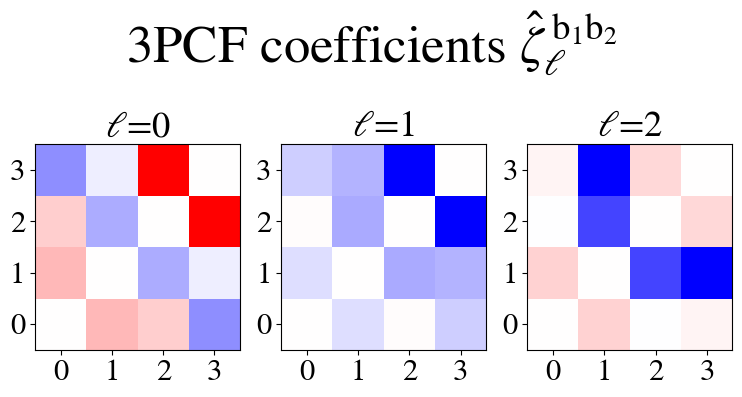

In [38]:
plt.figure(figsize=(9,6))
for ell in range(0, ell_max+1, 1):
  img = zeta[ell,:,:].real
  plt.subplot(2,3,ell+1)
  plt.title('$\ell$='+str(ell))
  im = plt.imshow(img, origin='lower', cmap="bwr", vmin=-np.max(np.abs(img)), vmax=np.max(np.abs(img)))
  plt.xticks(range(nbins))
  plt.yticks(range(nbins))
  if ell == 3:
    plt.xlabel('bin 1')
    plt.ylabel('bin 2') 
plt.suptitle('3PCF coefficients $\\hat{\\zeta}_{\\ell}^{\; \mathrm{b}_1 \mathrm{b}_2}$', fontsize='xx-large', y =1.1)
plt.show()

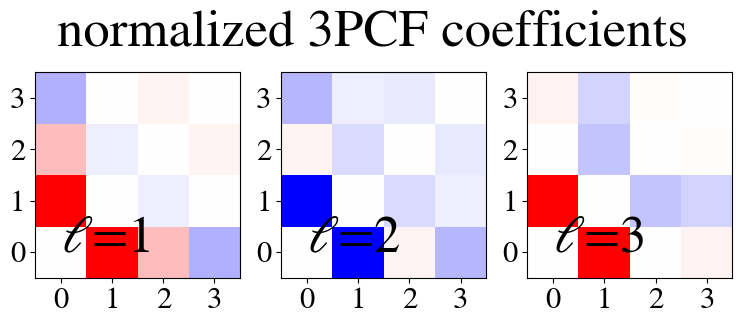

In [39]:
#Normalize
N_gal = np.sum(data + 1) #for data with mean of 0
nbar = (N_gal) / boxsize**3

binvolume = boundsandnumber[1,0:nbins]
V_cell = (boxsize / ld_one_d)**3
bin_volumes = (binvolume[:,None] * binvolume[None,:]) * V_cell**2
normalize_coeff = 1 / (N_gal * bin_volumes * nbar**2) 
normed_zeta = zeta * normalize_coeff

plt.figure(figsize=(9,6))
for ell in range(0, ell_max+1, 1):
  img = normed_zeta[ell,:,:].real
  plt.subplot(2,3,ell+1)
  plt.text(0,0,'$\ell$='+str(ell+1), c='black', fontsize='xx-large')
  plt.imshow(img, origin='lower', cmap="bwr", vmin=-np.max(np.abs(img)), vmax=np.max(np.abs(img)))
  plt.xticks(range(nbins))
  plt.yticks(range(nbins))
  if ell == 3:
    plt.xlabel('bin 1')
    plt.ylabel('bin 2')

plt.suptitle('normalized 3PCF coefficients', fontsize='xx-large')
plt.show()

In [46]:
from sympy.physics.wigner import wigner_3j

def calc_CG_coeffs(ell_max):
    CG_Coefficients = np.zeros((ell_max + 1, ell_max + 1, ell_max + 1, 
                                2 * ell_max + 1,2 * ell_max + 1,2 * ell_max + 1))
    
    for l_1 in range(0, ell_max + 1):
        for l_2 in range(0, ell_max + 1):
            for l_3 in range(0, ell_max + 1):
                for m_1 in range(-l_1, l_1 + 1):
                    for m_2 in range(-l_2, l_2 + 1):
                        for m_3 in range(-l_3, l_3 + 1):
                            value = float(wigner_3j(l_1, l_2, l_3, m_1, m_2, m_3))
                            CG_Coefficients[l_1, l_2, l_3, m_1, m_2, m_3] = value

    return CG_Coefficients


CG_Coefficients = calc_CG_coeffs(5)

In [51]:
def S(m):
    """
    A simple function defined in section 4.1.1 of
    Philcox et al. 2021 above algorithm 3. (Helper Function)
    """
    if m == 0:
        return 1 / 2
    return 1


binvolume = boundsandnumber[1, 0:nbins]

zeta = np.zeros((ell_max + 1, ell_max + 1, ell_max + 1, nbins, nbins, nbins)) + 0j

start = time.time()
for l_1 in range(0, ell_max + 1):
    for l_2 in range(0, ell_max + 1):
        for l_3 in range(np.abs(l_1 - l_2), min(l_1 + l_2, ell_max) + 1):
            if (l_1 + l_2 + l_3) % 2 != 0:  # only looking at even parity modes for now
                continue
            for m_1 in range(-l_1, l_1 + 1):
                for m_2 in range(-l_2, l_2 + 1):
                    m_3 = -m_1 - m_2
                    if m_3 > l_3 or m_3 < 0:
                        continue
                    coupling_w = (data * (-1) ** (l_1 + l_2 + l_3)
                                  * CG_Coefficients[l_1, l_2, l_3, m_1, m_2, m_3])
                    for b_1 in range(0, nbins):
                        if m_1 < 0:
                            a_lmb_1 = (-1) ** m_1 * (
                                np.load(
                                    save_name + "conv_data_kernel_" + kernel_name
                                    + "_" + str(l_1) + "_" + str(-m_1) + "_bin_" + str(b_1)
                                    + ".npy"
                                ).astype(np.complex128)
                            ).conjugate()
                        #
                        else:
                            a_lmb_1 = np.load(
                                save_name + "conv_data_kernel_" + kernel_name
                                + "_" + str(l_1) + "_" + str(m_1) + "_bin_" + str(b_1)
                                + ".npy"
                            ).astype(np.complex128)
                        #
                        for b_2 in range(b_1 + 1, nbins): 
                            if m_2 < 0:
                                a_lmb_2 = (-1) ** m_2 * (
                                    np.load(
                                        save_name + "conv_data_kernel_" + kernel_name
                                        + "_" + str(l_2) + "_" + str(-m_2) + "_bin_" + str(b_2)
                                        + ".npy"
                                    ).astype(np.complex128)
                                ).conjugate()
                            #
                            else:
                                a_lmb_2 = np.load(
                                    save_name + "conv_data_kernel_" + kernel_name
                                    + "_" + str(l_2) + "_" + str(m_2) + "_bin_" + str(b_2)
                                    + ".npy"
                                ).astype(np.complex128)
                            #
                            for b_3 in range(b_2 + 1, nbins): 
                                a_lmb_3 = np.load(
                                    save_name + "conv_data_kernel_" + kernel_name
                                    + "_" + str(l_3) + "_" + str(m_3) + "_bin_" + str(b_3)
                                    + ".npy"
                                ).astype(np.complex128)
                                #
                                zeta[l_1, l_2, l_3, b_1, b_2, b_3] += np.sum(2 * S(m_3) * 
                                                                             coupling_w * np.real(a_lmb_1 * a_lmb_2 * a_lmb_3))

for l1 in range(0, ell_max + 1):
    for l2 in range(0, ell_max + 1):
        for l3 in range(np.abs(l1 - l2), min(l1 + l2, ell_max) + 1):
            if (l1 + l2 + l3) % 2 != 0:  
                continue
            for b1 in range(0, nbins):
                for b2 in range(b1 + 1, nbins):
                    for b3 in range(b2 + 1, nbins):
                        this_4pcf = zeta[l1, l2, l3, b1, b2, b3]
                        zeta[l3, l1, l2, b3, b1, b2] = this_4pcf
                        zeta[l2, l3, l1, b2, b3, b1] = this_4pcf
                        zeta[l1, l3, l2, b1, b3, b2] = this_4pcf
                        zeta[l2, l1, l3, b2, b1, b3] = this_4pcf
                        zeta[l3, l2, l1, b3, b2, b1] = this_4pcf

stop = time.time()

print(f"Full 4PCF Calculation Took: {stop - start:0.2f} seconds")

Full 4PCF Calculation Took: 239.74 seconds


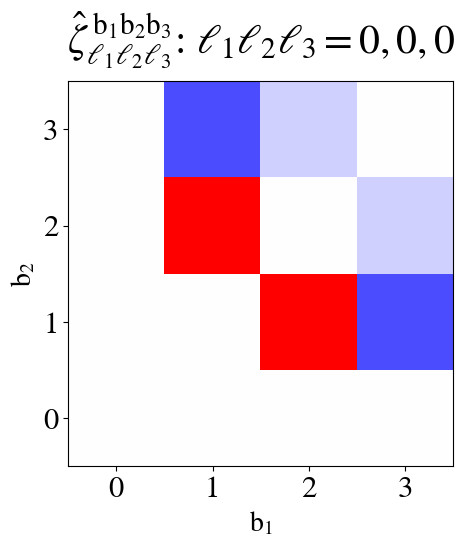

In [48]:
img = zeta[0,0,0,:,:,0].real

plt.figure(figsize=(6,5))
plt.imshow(img, origin='lower', cmap="bwr", vmin=-np.max(np.abs(img)), vmax=np.max(np.abs(img)))
plt.xticks(range(nbins))
plt.yticks(range(nbins))
plt.xlabel("$\mathrm{b}_1$", fontsize=20)
plt.ylabel("$\mathrm{b}_2$", fontsize=20)
plt.title("$\\hat{\\zeta}_{\\ell_1 \\ell_2 \\ell_3}^{\; \mathrm{b}_1 \mathrm{b}_2 \mathrm{b}_3}$: $\\ell_1 \\ell_2 \\ell_3 = 0,0,0$", pad = 20, fontsize=30)
plt.show()

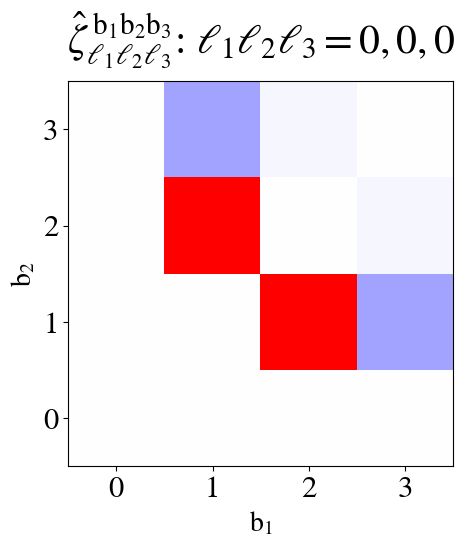

In [49]:
#Normalize
N_gal = np.sum(data + 1) #for data with mean of 0
nbar = (N_gal) / boxsize**3

binvolume = boundsandnumber[1,0:nbins]
V_cell = (boxsize / ld_one_d)**3
bin_volumes = (binvolume[:,None, None] * binvolume[None,:, None] * binvolume[None, None, :]) * V_cell**3
normalize_coeff = 1 / (N_gal * bin_volumes * nbar**3) 
normed_zeta = zeta * normalize_coeff


img = normed_zeta[0,0,0,:,:,0].real

plt.figure(figsize=(6,5))
plt.imshow(img, origin='lower', cmap="bwr", vmin=-np.max(np.abs(img)), vmax=np.max(np.abs(img)))
plt.xticks(range(nbins))
plt.yticks(range(nbins))
plt.xlabel("$\mathrm{b}_1$", fontsize=20)
plt.ylabel("$\mathrm{b}_2$", fontsize=20)
plt.title("$\\hat{\\zeta}_{\\ell_1 \\ell_2 \\ell_3}^{\; \mathrm{b}_1 \mathrm{b}_2 \mathrm{b}_3}$: $\\ell_1 \\ell_2 \\ell_3 = 0,0,0$", pad = 20, fontsize=30)
plt.show()